# Joint Representation Learning

In many problems, our network might be more than just the information contained in its adjacency matrix (called its topology, or its collection of nodes and edges). If we were investigating a social network, we might have access to extra information about each person -- their gender, for instance, or their age. If we were investigating a brain network, we might have information about the physical location of neurons, or the volume of a brain region. When we we embed a network, it seems like we should be able to use these extra bits of information - called the "features" or "covariates" of a network - to somehow improve our analysis. The techniques and tools that we'll explore in this section use both the covariates and the topology of a network to create and learn from new representations of the network. Because they jointly use both the topology of the network and its extra covariate information, these techniques and tools are called joint representation learning.

There are two primary reasons that we might want to explore using node covariates in addition to topological structure. First, they might improve our standard embedding algorithms, like Laplacian and Adjacency Spectral Embedding. For example, if the latent structure of the covariates of a network lines up with the latent structure of its topology, then we might be able to reduce noise when we embed, even if the communities in our network don't overlap perfectly with the communities in our covariates. Second, figuring out what the clusters of an embedding actually mean can sometimes be difficult and covariates create a natural structure in our network that we can explore. Covariate information in brain networks telling us where in the brain each node is, for instance, might let us better understand the types of characteristics that distinguish between different brain regions.

In this section, we'll explore different ways to learn from our data when we have access to the covariates of a network in addition to its topological structure. We'll explore *Covariate-Assisted Spectral Embedding* (CASE), a variation on Spectral Embedding. In CASE, instead of embedding just the adjacency matrix or its regularized Laplacian, we'll combine the Laplacian and our covariates into a new matrix and embed that.

A good way to illustrate how using covariates might help us is to use a model in which some of our community information is in the covariates and some is in our topology. Using the Stochastic Block Model, we’ll create a simulation using three communities: the first and second community will be indistinguishable in the topological structure of a network, and the second and third community will be indistinguishable in its covariates. By combining the topology and the covariates, we'll get a nice embedding that lets us find three distinct community clusters.

### Stochastic Block Model

Suppose we have a network generated from a Stochastic Block Model (or, commonly, SBM) with three communities. In our adjacency matrix, which contains only our network's topological information, we'd like to create a situation where the first two communities are completely indistinguishable: Any random node in the first community will have exactly the same chance of being connected to another node in the first community or to a node in the second community. We'd like the third community to be distinct, with only a small probability that nodes in it will connect to nodes in either of the other two communities. 

The Python code below generates a matrix that looks like this. There are 1500 nodes, with 500 nodes per community. Because the $3 \times 3$ block probability matrix that generated this SBM has the same probability values (.3) in its upper-left $2 \times 2$ square, a node in community 1 has a 30% chance of being connected to either another node in community 1 or a node in community 2. As a result, in our adjacency matrix, we'll see the nodes in communities one and two as a single giant block. On the other hand, nodes in community three only have a 15% chance to connect to nodes in the first community. So, the end result is that we've created a situation where we have three communities that we'd like to separate into distinct clusters, but the topological structure in the adjacency matrix can't separate the three groups by itself.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(42)

In [2]:
import numpy as np
from graspologic.simulations import sbm

# Start with some simple parameters
N = 1500  # Total number of nodes
n = N // 3  # Nodes per community
p, q = .3, .15
B = np.array([[.3, .3, .15],
              [.3, .3, .15],
              [.15, .15, .3]])  # Our block probability matrix

# Make our Stochastic Block Model
A, labels = sbm([n, n, n], B, return_labels = True)

Here you can see what our adjacency matrix looks like. Notice the giant block in the top-left: this block contains both nodes in both of the first two communities, and they're indistinguishable from each other.

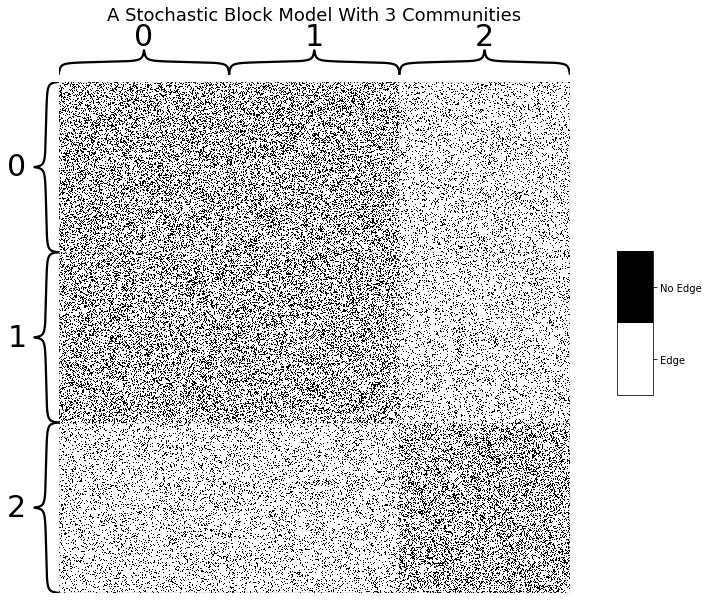

In [3]:
import matplotlib.pyplot as plt
from graphbook_code import heatmap
import matplotlib

# visualize
fig, ax = plt.subplots(figsize=(10,10))

def plot_heatmap(A, ax, title="A Stochastic Block Model With 3 Communities", show_cbar=True):
    cmap = matplotlib.colors.ListedColormap(["white", 'black'])
    ax = heatmap(A, cmap=cmap, ax=ax, inner_hier_labels=labels, 
                 title=title, center=None, cbar=False)
    ax.set_frame_on(False)
    if show_cbar:
        fig = plt.gcf()
        cax = fig.add_axes([0.95, 0.4, 0.05, 0.2])
        colorbar = fig.colorbar(ax.imshow(A, cmap=cmap), cax=cax)
        colorbar.set_ticks([0.25, 0.75])
        colorbar.set_ticklabels(["Edge", "No Edge"])
        cax.set_frame_on(True)
            
        
plot_heatmap(A, ax)

If we wanted to embed this graph using our Laplacian or Adjacency Spectral Embedding methods, we'd find the first and second communities layered on top of each other (though we wouldn't be able to figure that out from our embedding if we didn't cheat by knowing in advance which community each node is supposed to belong to). The python code below embeds our latent positions all the way down to two dimensions. Below it, you can see a plot of the latent positions, with each node color-coded by its true community.

In [4]:
from graspologic.embed import LaplacianSpectralEmbed as LSE
from graspologic.utils import to_laplacian

L = to_laplacian(A, form="R-DAD")
L_latents = LSE(n_components=2).fit_transform(L)

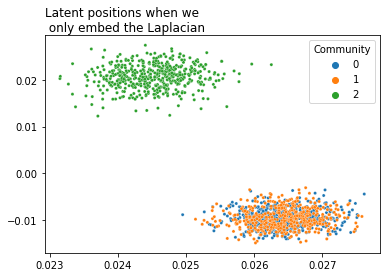

In [5]:
import seaborn as sns
from graphbook_code import plot_latents

plot = plot_latents(L_latents, title="Latent positions when we\n only embed the Laplacian", 
                    labels=labels)

As you can see, we'd have a tough time clustering this - the first and second community are completely indistinguishable. It would be nice if we could use extra information to more clearly distinguish between them. We don't have this information in our adjacency matrix: it needs to come from somewhere else.

### Covariates

But we're in luck - we have a set of covariates for each node! These covariates contain the extra information we need that allows us to separate our first and second community. However, with only these extra covariate features, we can no longer distinguish between the last two communities - they contain the same information.

Below is Python code that generates these covariates. Each node is associated with its own group of 30 covariates (thirty being chosen primarily to visualize what's happening more clearly). We'll organize this information into a matrix, where the $i_{th}$ row contains the covariates associated with node $i$. Remember that we have 1500 nodes in our network, so there will be 1500 rows. We'll draw all the covariates for each node from the same Beta distribution (with values ranging from 0 to 1), but the nodes in the first community will be drawn from a different Beta distribution than the nodes in the last two. 

In [6]:
from scipy.stats import beta

def make_community(a, b, n=500):
    return beta.rvs(a, b, size=(n, 30))

def gen_covariates():
    c1 = make_community(2, 5)
    c2 = make_community(2, 2)
    c3 = make_community(2, 2)

    covariates = np.vstack((c1, c2, c3))
    return covariates
    

# Generate a covariate matrix
Y = gen_covariates()

Here is a visualization of the covariates we just created. The first community is represented by the lighter-colored rows, and the last two are represented by the darker-colored rows.

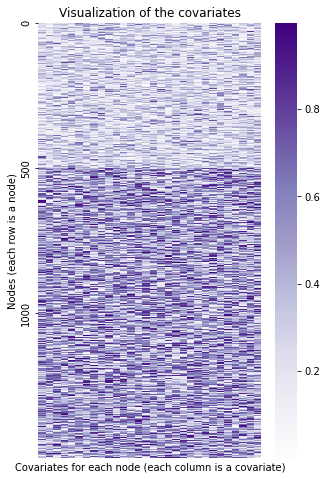

In [7]:
from graphbook_code import GraphColormap

# Plot and make the axis look nice
cmap = GraphColormap("sequential", discrete=False).palette
fig, ax = plt.subplots(figsize=(5, 8))
ax = sns.heatmap(Y, ax=ax, cmap=cmap, yticklabels=500)
ax.set(title="Visualization of the covariates", xticks=[], 
       ylabel="Nodes (each row is a node)",
       xlabel="Covariates for each node (each column is a covariate)");

We can play almost the same game here as we did with the Laplacian. If we embed the information contained in this matrix of covariates into lower dimensions, we can see the reverse situation as before - the first community is separate, but the last two are overlayed on top of each other.

Below is Python code that embeds the covariates. We'll use custom embedding code rather than graspologic's LSE class, because it isn't technically right to act as if we're embedding a Laplacian (even though we're doing essentially the same thing under the hood). Underneath it is a plot of the resulting embedding.

In [8]:
from sklearn.utils.extmath import randomized_svd

def embed(matrix, *, dimension):
    latents, _, _ = randomized_svd(matrix, n_components=dimension)
    return latents

Y_latents = embed(Y, dimension=2)

As you can see, we're in a similar situation as we were in with the adjacency matrix, but with different communities: instead of the first and second communities being indistinguishable, now the second and third are. We'd like to see full separation between all three communities, so we need some kind of representation of our network that allows us to use both the information in the topology and the information in the covariates. This is where CASE comes in.

## Covariate-Assisted Spectral Embedding

<i>Covariate-Assisted Spectral Embedding</i>, or CASE<sup>1</sup>, is a simple way of combining our network and our covariates into a single model. In the most straightforward version of CASE, we combine the network's regularized Laplacian matrix $L$ and a function of our covariate matrix $YY^\top$. Here, $Y$ is just our covariate matrix, in which row $i$ contains the covariates associated with node $i$. Notice the word "regularized" - This means (from the Laplacian section earlier) that our Laplacian looks like $L = L_{\tau} = D_{\tau}^{-1/2} A D_{\tau}^{-1/2}$ (remember, $D$ is a diagonal matrix with $D_{ii}$ telling us the degree of node $i$).

```{note}
Suppose that $Y$ only contains 0's and 1's. To interpret $YY^T$, notice we're effectively taking the the dot product of each row of $Y$ with each other row, because the transpose operation turns rows into columns. Now, look at what happens below when we take the dot product of two example vectors with only 0's and 1's in them:

\begin{align}
\begin{bmatrix}
1 & 1 & 1
\end{bmatrix} \cdot 
\begin{bmatrix}
0 \\
1 \\
1 \\
\end{bmatrix} = 1\times 0 + 1\times 1 + 1\times 1 = 2
\end{align}

If there are two overlapping 1's in the same position of the left vector and the right vector, then there will be an additional 1 added to their weighted sum. So, in the case of a binary $YY^T$, when we matrix-multiply a row of $Y$ by a column of $Y^T$, the resulting value, $(YY^T)_{i, j}$, will be equal to the number of shared locations in which vectors $i$ and $j$ both have ones.
```

A particular value in $YY^\top$, $(YY^\top)_{i, j}$, can be interpreted as measuring the "agreement" or "similarity" between row $i$ and row $j$ of our covariate matrix. Since each row represents the covariates for a particular node, the higher the value of $(YY^\top)_{i, j}$, the more similar the covariates of the $i_{th}$ and $j_{th}$ nodes are. The overall result is a matrix that looks fairly similar to our Laplacian!  

The following Python code generates our covariate similarity matrix $YY^\top$. We'll also normalize the rows of our covariate matrix to have unit length using scikit-learn - this is because we want the scale for our covariate matrix to be roughly the same as the scale for our adjacency matrix. Later, we'll weight $YY^\top$ to help with this as well.

In [9]:
from sklearn.preprocessing import normalize

Y = normalize(Y, axis=0)
YYt = Y@Y.T

Below, you can see the Laplacian we generated earlier next to $YY^\top$. Remember, each matrix contains information about our communities that the other doesn't have - and our goal is to combine them in a way that lets us distinguish between all three communities.

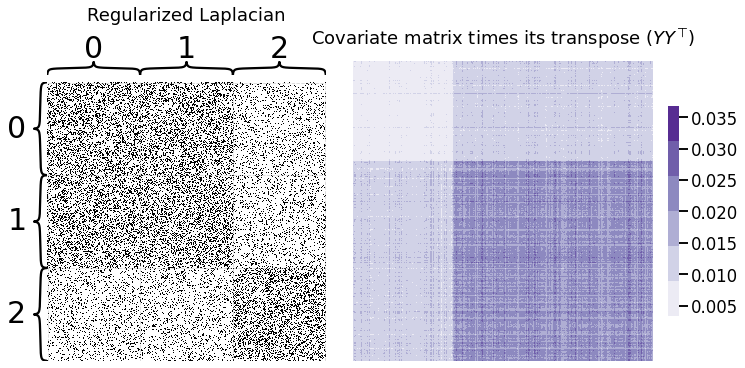

In [10]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), constrained_layout=True)
L_ax = plot_heatmap(L, title=r"Regularized Laplacian", ax=axs[0], show_cbar=False)
X_ax = heatmap(YYt, title=r"Covariate matrix times its transpose ($YY^\top$)", ax=axs[1]);

The way we'll combine the two matrices will simply be a weighted sum of these two matrices - this is what CASE is doing under the hood. The weight (here called $\alpha$) is multiplied by $YY^\top$ - that way, both matrices contribute an equal amount of useful information to the embedding. 

$$
L + \alpha YY^\top
$$

### Exploring Possible Weights

An obvious question here is how to weight the covariates. If we simply summed the two matrices by themselves, we'd unfortunately be in a situation where whichever matrix contained larger numbers would dominate over the other. In our current setup, without a weight on $YY^\top$, the covariates of our network would dominate over its topology.

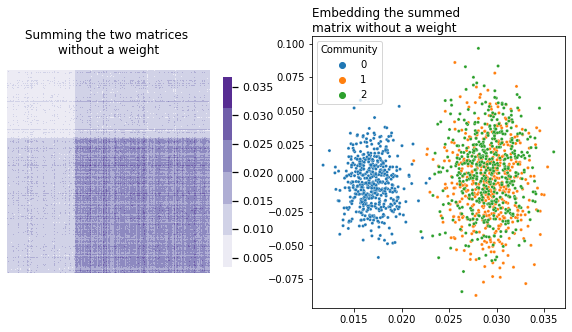

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
heatmap(L + Y@Y.T, title="Summing the two matrices \nwithout a weight", ax=axs[0], context='notebook');
plot_latents(embed(L + Y@Y.T, dimension=2), title="Embedding the summed \nmatrix without a weight", 
             ax=axs[1], labels=labels);

What do different potential weights look like? Let's do a comparison. Below you can see the embeddings for 9 possible weights on $YY^\top$, ranging between $10^{-5}$ and 100.

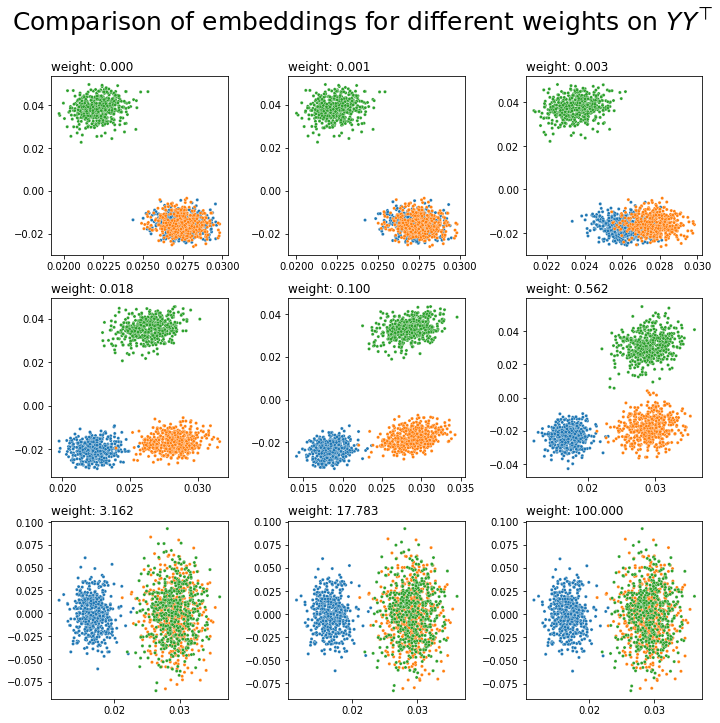

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for a, ax in zip(np.geomspace(10e-5, 100, num=9), axs.flat):
    l_ = embed(L+a*YYt, dimension=2)
    plot_latents(l_, title=f"weight: {a:.3f}", labels=labels, ax=ax)
    ax.get_legend().remove()

fig.suptitle(r"Comparison of embeddings for different weights on $YY^\top$", y=1, fontsize=25);
plt.tight_layout()

It looks like we'd probably want a weight somewhere between 0.01 and 0.5  - then, we'll have three communities which are fairly distinct from each other, implying that we're pulling good information from both our network's topology and its covariates. We could just pick our weight manually, but it would be nice to have some kind of algorithm or equation which lets us pick a reasonable weight automatically.

### Finding a Reasonable Weight Automatically

In general, we'd like to embed in a way that lets us distinguish between communities. This means that if we knew which community each node belonged to, we'd like to be able to correctly retrieve the correct commmunities for each node as possible with a clustering algorithm after embedding. This also implies that the communities will be as distinct as possible.

We already found a range of possible weights, embedded our combined matrix for every value in this range, and then looked at which values produced the best clustering. But, how do we find a weight which lets us consistently use useful information from both the topology and the covariates?

When we embed symmetric matrices, keep in mind that the actual points we're plotting are the components of the eigenvectors with the biggest eigenvalues. When we embed into two-dimensional space, for instance, the X-axis values of our points are the components of the eigenvector with the biggest eigenvalue, and the Y-axis values are the components of the eigenvector with the second-biggest eigenvalue. This means that we should probably be thinking about how much information the Laplacian and $YY^\top$ contributes to the biggest eigenvalue/eigenvector pairs. 

Thinking about this more, if we have a small weight, $YY^\top$ will contribute only a small amount to the biggest eigenvalue/vector pair. If we have a large weight, $YY^\top$ will contribute a large amount to the biggest eigenvalue/vector pair. The weight that causes the Laplacian and $YY^\top$ to contribute the same amount of information, then, is just the ratio of the biggest eigenvalue of $L$ and the biggest eigenvalue of $YY^\top$:

$$
weight = \frac{\lambda_1 (L)}{\lambda_1 (YY^\top)}
$$

Let's check what happens when we combine our Laplacian and covariates matrix using the weight described in the equation above. Our embedding works the same as it does in Laplacian Spectral Embedding: we decompose our combined matrix using Singular Value Decomposition, truncating the columns, and then we visualize the rows of the result. Remember, we'll be embedding $L + \alpha YY^\top$, where $\alpha$ is our weight. We'll embed all the way down to two dimensions, just to make visualization simpler.

In [13]:
from scipy.sparse.linalg import eigsh

# Find the biggest eigenvalues in both of our matrices
leading_eigval_L, = eigsh(L, return_eigenvectors=False, k=1)
leading_eigval_YYt, = eigsh(YYt, return_eigenvectors=False, k=1)

# Per our equation above, we get the weight using
# the ratio of the two biggest eigenvalues.
weight = leading_eigval_L / leading_eigval_YYt

# Do our weighted sum, then embed
L_ = L + weight*YYt
latents_ = embed(L_, dimension=2)

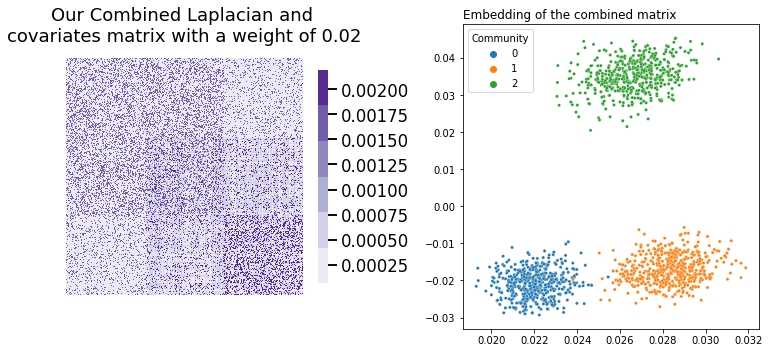

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
heatmap(L_, title=f"Our Combined Laplacian and \ncovariates matrix with a weight of {weight:.2f}", ax=axs[0])
plot_latents(latents_, 
             title=f"Embedding of the combined matrix", 
             labels=labels, ax=axs[1]);

plt.tight_layout()

Success! We've managed to achieve separation between all three communities. Below we can see (from left to right) a comparison of our network's latent position when we only use its topological information, when we only use the information contained in its covariates, and finally our embedding using the weight we found.

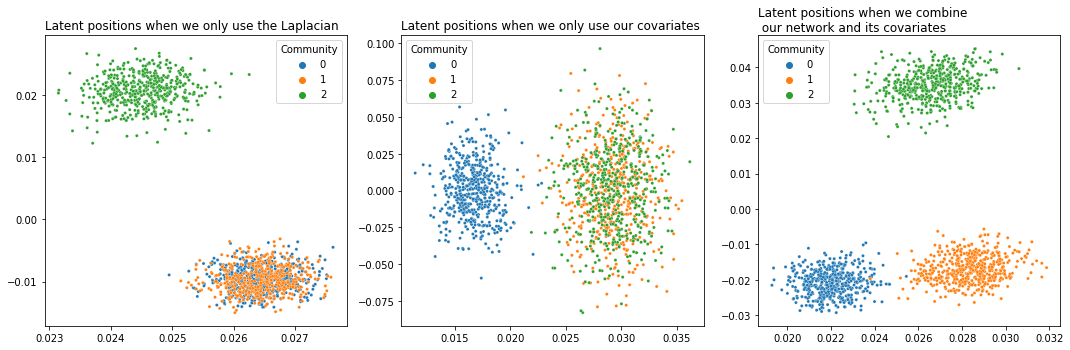

In [15]:
from graspologic.embed import LaplacianSpectralEmbed as LSE


# Plot
fig, axs = plt.subplots(1, 3, figsize=(15,5))
plot_latents(L_latents, title="Latent positions when we only use the Laplacian", 
             labels=labels, ax=axs[0])
plot_latents(Y_latents, title="Latent positions when we only use our covariates", 
             labels=labels, ax=axs[1]);
plot_latents(latents_, title="Latent positions when we combine\n our network and its covariates", 
             labels=labels, ax=axs[2])

plt.tight_layout()

## Using Graspologic

Graspologic's CovariateAssistedSpectralEmbedding class implements CASE directly. The following code applies CASE to reduce the dimensionality of $L + aYY^T$ down to two dimensions, and then plots the latent positions to show the clustering. 

```{admonition} Non-Assortative Networks 
We don't always necessarily want to embed $L + \alpha YY^\top$. Using the regularized Laplacian by itself, for instance, isn't always best. If your network is *non-assortative* - meaning, the between-block probabilities are greater than the within-block probabilities - it's better to square our Laplacian. This is because the adjacency matrices of non-assortative networks have a lot of negative eigenvalues; squaring the Laplacian gets rid of a lot of annoying negative eigenvalues, and we end up with a better embedding. In the non-assortative case, we end up embedding $LL + aYY^\top$. The `embedding_alg` parameter controls this: you can write `embedding_alg="non-assortative"` if you're in the non-assortative situation.
```

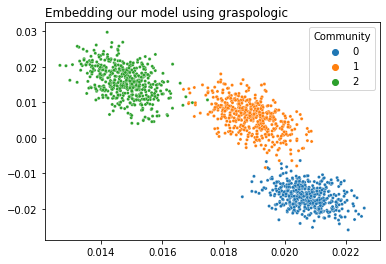

In [16]:
from graspologic.embed import CovariateAssistedEmbed as CASE

casc = CASE(assortative=True, n_components=2)
latents = casc.fit_transform(A, covariates=Y)
plot_latents(latents, title="Embedding our model using graspologic", labels=labels);

## Omnibus Joint Embedding

If you've read the Multiple-Network Representation Learning section, you've seen the Omnibus Embedding (if you haven't read that section, you should go read it before reading this one!). To recap, the way the omnibus embedding works is:

1. Have a bunch of networks
2. Combine the adjacency matrices from all of those networks into a single, huge network
3. Embed that huge network

Remember that the Omnibus Embedding is a way to bring all of your networks into the same space (meaning, you don't run into any rotational nonidentifiability issues when you embed). Once you embed the Omnibus Matrix, it'll produce a huge latent position matrix, which you can break apart along the rows to recover latent positions for your individual networks.

You might be able to predict where this is going. What if we created an Omnibus embedding not with a set of networks, but with a network and covariates?

In [17]:
from graspologic.embed import OmnibusEmbed

# embed with Omni
omni = OmnibusEmbed()

# Normalize the covariates first
YYt = Y@Y.T
YYt /= np.max(YYt)

# Create a joint embedding
joint_embedding = omni.fit_transform([A, YYt])

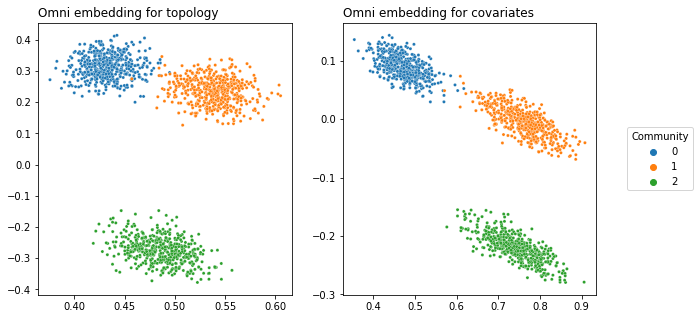

In [18]:
from graphbook_code import plot_latents

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# network
network_plot = plot_latents(joint_embedding[0], ax=axs[0], legend=None,
                            labels=labels, title="Omni embedding for topology")

# covariates
covariates_plot = plot_latents(joint_embedding[1], ax=axs[1], 
                               labels=labels, title="Omni embedding for covariates")
sns.move_legend(covariates_plot, loc="center right", bbox_to_anchor=(1.4, .5))

There's a few things going on here. First, we had to normalize the covariates by dividing $YY^\top$ by its maximum. This is because if we didn't, the covariates and the adjacency matrix would contribute vastly different amounts of information to the omnibus matrix. You can see that by looking at the average value of $YY^\top$ compared to the average value of $A$:

In [19]:
print(r"Mean of Y@Y.T:", f"{np.mean(Y@Y.T):.2f}")
print(r"Mean of A:", f"{np.mean(A):.2f}")

Mean of Y@Y.T: 0.02
Mean of A: 0.23


In [20]:
print(r"Mean of normalized Y@Y.T:", f"{np.mean(YYt):.2f}")
print(r"Mean of A:", f"{np.mean(A):.2f}")

Mean of normalized Y@Y.T: 0.42
Mean of A: 0.23


Remember the way this data is set up: you can separate the first community from the last two with the topology, you can separate the last community from the first two with the covariates, but you need both data sources to separate all three. 

Here, you can see that *both embeddings* are able to separate all three communities. This is because the Omnibus Embedding induces dependence on the latent positions it outputs. Remember that the off-diagonals of the Omnibus Matrix contain the averages of pairs of networks fed into it. These off-diagonal elements are responsible for some "information leakage": so the topology embedding contains information from the covariates, and the covariate embedding contains information from the topology.

## MASE Joint Embedding

Just like you can use the OMNI to do a joint embedding, you can also use MASE to do a joint embedding. This fundamentally comes down to the fact that both embeddings fundamentally just eat matrices as their input - whether those matrices are the adjacency matrix or $YY^\top$ doesn't really matter.

Just like OMNI, we'll quickly recap how MASE works here:
1. Have a bunch of networks
2. Embed them all separately with ASE or LSE
3. Concate those embeddings into a single latent position matrix with a lot more dimensions
4. Embed that new matrix

The difference here is the same as with Omni -- we have the adjacency matrix (topology) and its covariates for a single network. So instead of embedding a bunch of adjacency matrices or Laplacians, we embed the adjacency matrix (or Laplacian) and the similarity matrix for the covariates $YY^\top$ separately, concatenate, and then embed again.

In [21]:
from graspologic.embed import MultipleASE as MASE

# Remmeber that YY^T is still normalized!
mase = MASE(n_components=2)
joint_embedding = mase.fit_transform([A, YYt])

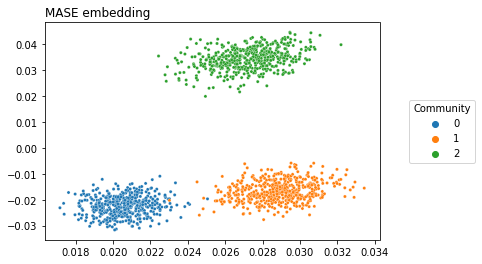

In [22]:
# network
plot = plot_latents(joint_embedding, labels=labels,
                            title="MASE embedding")

sns.move_legend(plot, loc="center right", bbox_to_anchor=(1.3, .5))

As you can see, MASE lets us get fairly clear separation between communities. The covariates are still normalized, as with OMNI, so that they can contribute the same amount to the embedding as the adjacency matrix.

#### References

[1] N. Binkiewicz, J. T. Vogelstein, K. Rohe, Covariate-assisted spectral clustering, Biometrika, Volume 104, Issue 2, June 2017, Pages 361–377, https://doi.org/10.1093/biomet/asx008  
[2] Lloyd, S. (1982). Least squares quantization in PCM. IEEE transactions on information theory, 28(2), 129-137.  
[3] https://scikit-learn.org/stable/modules/clustering.html#k-means  
[4] Hotelling, H. (1936). Relations between two sets of variates. Biometrika 28, 321–77.  